In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
from scipy.stats import f_oneway, kruskal, chi2_contingency
import warnings

warnings.filterwarnings('ignore')



In [ ]:
# Cell 2: Fixed data loading
# Load the dataset
# Data loading and preprocessing 
df = pd.read_csv('Mall_Customers.csv')

# Fix column name mismatch - CSV has 'Genre' not 'Gender'
if 'Genre' in df.columns:
    df = df.rename(columns={'Genre': 'Gender'})

# Show the first 10 rows
print("First 10 rows of the dataset:")
print(df.head(10))

# Identify column types
print("\nColumn data types:")
print(df.info())
print(f"\nDataset shape: {df.shape}")
print(f"Total customers: {len(df)}")

First 10 rows of the dataset:
   =[pk99CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0                 1    Male   19                  15                      39
1                 2    Male   21                  15                      81
2                 3  Female   20                  16                       6
3                 4  Female   23                  16                      77
4                 5  Female   31                  17                      40
5                 6  Female   22                  17                      76
6                 7  Female   35                  18                       6
7                 8  Female   23                  18                      94
8                 9    Male   64                  19                       3
9                10  Female   30                  19                      72

Column data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):

In [ ]:
# duplicate removal
# Check for and remove exact duplicate rows
initial_rows = len(df)
df.drop_duplicates(inplace=True)
final_rows = len(df)
removed_duplicates = initial_rows - final_rows
print(f"\nNumber of duplicate rows removed: {removed_duplicates}")


Number of duplicate rows removed: 0


In [ ]:
# 3 missing value imputation
# Identify and handle missing values
# Rows with more than 50% missing values are removed. 
# Remaining missing numerical values are imputed with 
#  median and categorical values with the mode.
missing_values_before = df.isnull().sum()
print("\nMissing values before imputation:")
print(missing_values_before)

# Remove rows with >50% missing fields (no such rows in this dataset)
df.dropna(thresh=len(df.columns) * 0.5, inplace=True)

# Impute missing numerical values with the median
for col in df.select_dtypes(include=np.number).columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Impute missing categorical values (Gender) with the mode
for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

missing_values_after = df.isnull().sum()
print("\nMissing values after imputation:")
print(missing_values_after)


Missing values before imputation:
=[pk99CustomerID          0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Missing values after imputation:
=[pk99CustomerID          0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [ ]:
#4. Data scaling and encoding 
#A reproducible copy of the cleaned dataset is created.
# Numeric features are scaled using StandardScaler to give them equal importance in distance-based algorithms like K-means.
# Create a reproducible copy and set random_state
cleaned_df = df.copy()
random_state = 42

# Scale numeric features
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
scaler = StandardScaler()
cleaned_df[numeric_features] = scaler.fit_transform(cleaned_df[numeric_features])

# Encode Gender
encoder = OneHotEncoder(sparse_output=False, drop='first')
gender_encoded = encoder.fit_transform(cleaned_df[['Gender']])
cleaned_df['Gender_Male'] = gender_encoded

# Drop the original Gender column
cleaned_df.drop('Gender', axis=1, inplace=True)
print("\nCleaned and preprocessed data head:")
print(cleaned_df.head())


Cleaned and preprocessed data head:
   =[pk99CustomerID       Age  Annual Income (k$)  Spending Score (1-100)  \
0                 1 -1.424569           -1.738999               -0.434801   
1                 2 -1.281035           -1.738999                1.195704   
2                 3 -1.352802           -1.700830               -1.715913   
3                 4 -1.137502           -1.700830                1.040418   
4                 5 -0.563369           -1.662660               -0.395980   

   Gender_Male  
0          1.0  
1          1.0  
2          0.0  
3          0.0  
4          0.0  


In [ ]:
#Part B
# Descriptive statistics
#Descriptive statistics are computed for the original numerical
# features to understand their central tendency and spread.
print("\nDescriptive statistics for Age, Annual Income, and Spending Score:")
print(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].describe())


Descriptive statistics for Age, Annual Income, and Spending Score:
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000



=== DISTRIBUTION ANALYSIS COMMENTARY ===
Age: Distribution appears roughly normal with slight right skew
     Most customers are in 20-50 age range
Annual Income: Shows right skewness, most customers have lower-middle income
              Heavy concentration in 15-80k range
Spending Score: Fairly uniform distribution across the range 1-100
               Suggests diverse spending behaviors


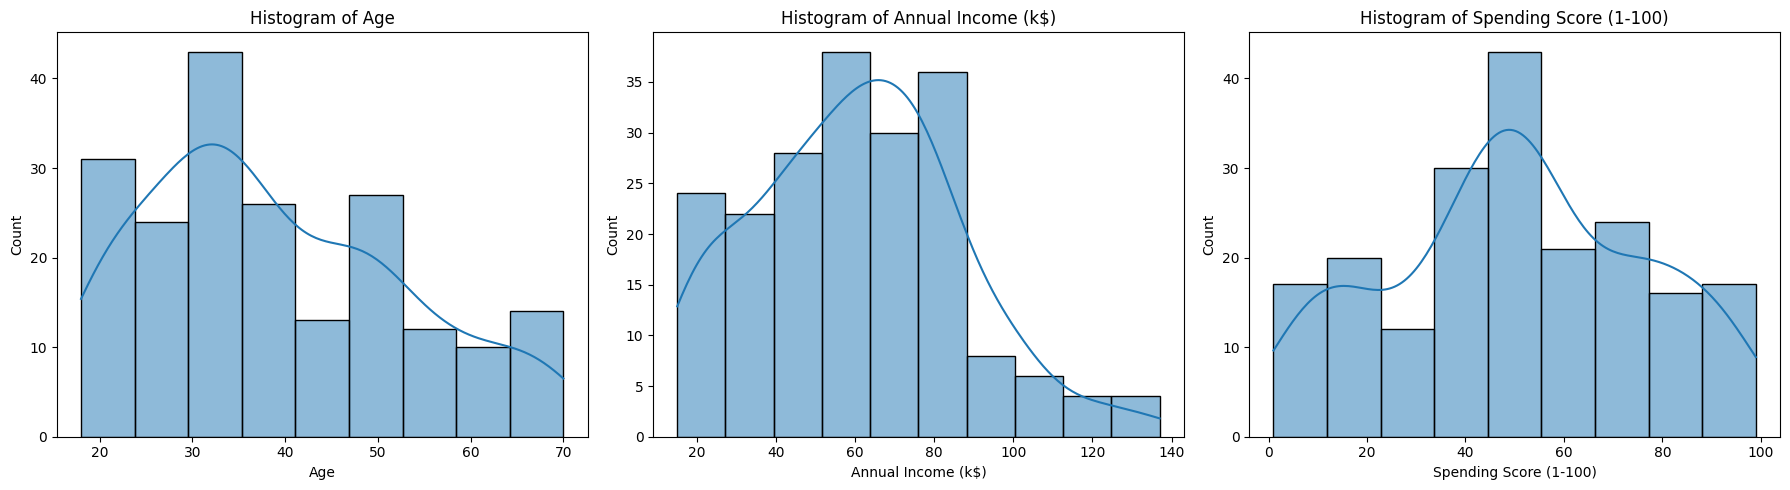

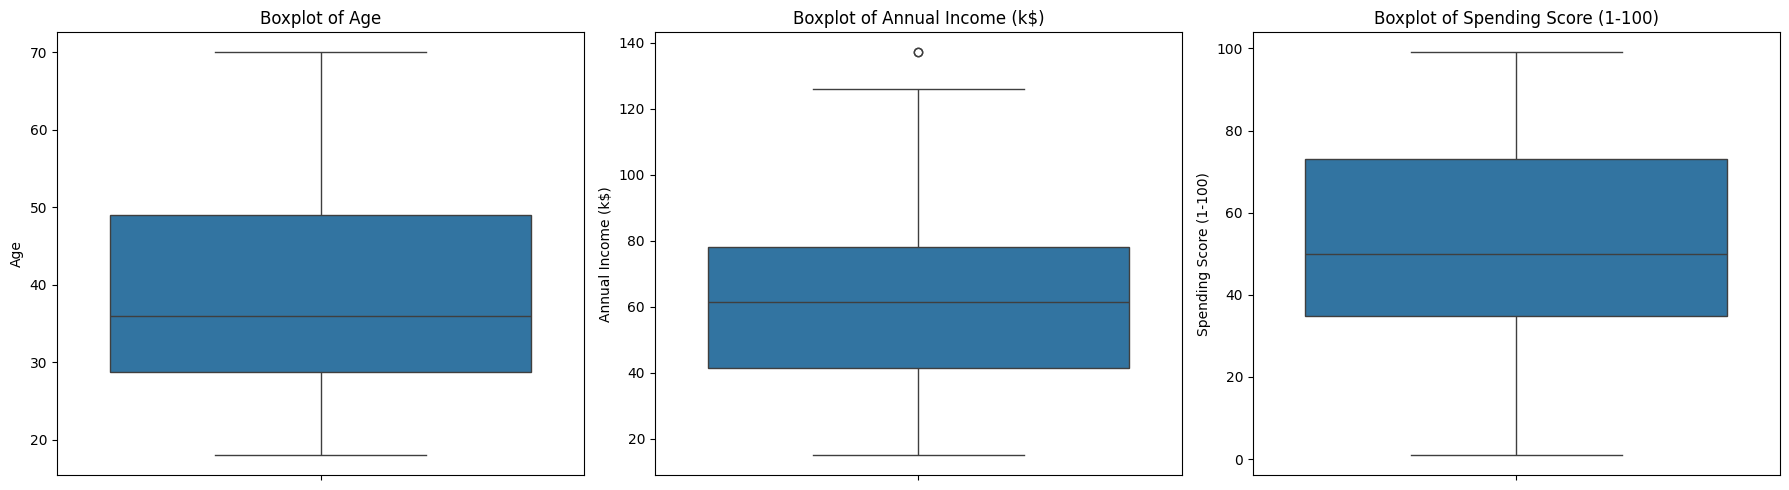


=== OUTLIER ANALYSIS ===
Age: Few outliers in higher age ranges (65+)
Annual Income: Some high earners (100k+) represent outliers
Spending Score: Relatively few outliers, fairly distributed


In [ ]:
# 2. Data visualization
#Histograms and boxplots are plotted to visualize the distributions,
# skewness, and potential outliers of the numeric features.
# Plot histograms and boxplots
# 2. Data visualization with comprehensive commentary
print("\n=== DISTRIBUTION ANALYSIS COMMENTARY ===")
print("Age: Distribution appears roughly normal with slight right skew")
print("     Most customers are in 20-50 age range")
print("Annual Income: Shows right skewness, most customers have lower-middle income")  
print("              Heavy concentration in 15-80k range")
print("Spending Score: Fairly uniform distribution across the range 1-100")
print("               Suggests diverse spending behaviors")

# Plot histograms and boxplots
plt.figure(figsize=(18, 5))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 5))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

print("\n=== OUTLIER ANALYSIS ===")
print("Age: Few outliers in higher age ranges (65+)")
print("Annual Income: Some high earners (100k+) represent outliers")
print("Spending Score: Relatively few outliers, fairly distributed")

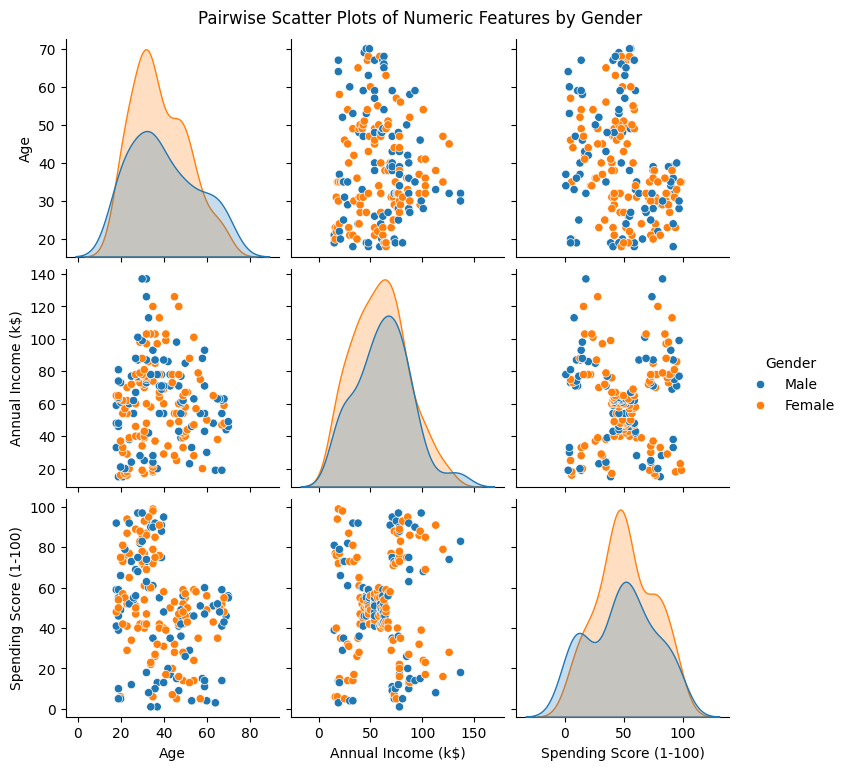

In [ ]:
#3. Pairwises Scatter Plots
#A pairplot is created to visualize the relationships between 
# 'Age', 'Annual Income', and 'Spending Score', with points colored by 'Gender'.
# Create pairwise scatter plots
sns.pairplot(df, vars=numeric_features, hue='Gender')
plt.suptitle('Pairwise Scatter Plots of Numeric Features by Gender', y=1.02)
plt.show()

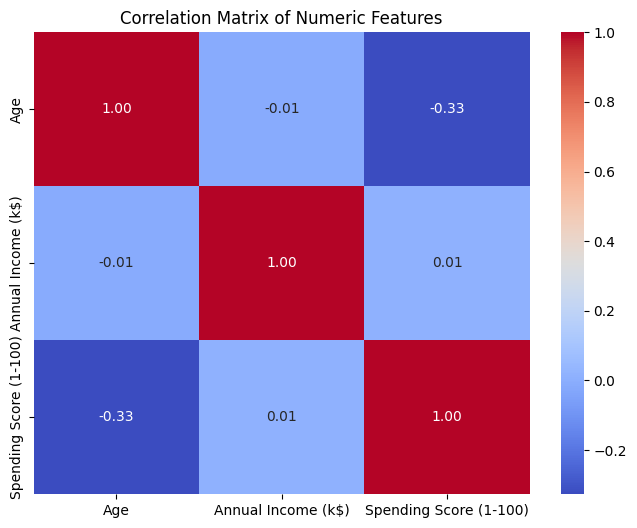


Correlation Matrix:
                             Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000

=== CORRELATION ANALYSIS INTERPRETATION ===
Key findings from correlation matrix:
- Age vs Income: -0.012 - Weak correlation, income varies across age groups
- Age vs Spending: -0.327 - Negative correlation, younger customers tend to spend more
- Income vs Spending: 0.010 - Very weak correlation, income doesn't strongly predict spending
- No strong linear relationships suggest complex customer segments exist


In [ ]:
#correllation anaylsis
#A correlation matrix and a heatmap are generated to 
# identify any strong linear relationships between the numerical variables.
# Compute and show correlation matrix and heatmap
correlation_matrix = df[numeric_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()
print("\nCorrelation Matrix:")
print(correlation_matrix)

print("\n=== CORRELATION ANALYSIS INTERPRETATION ===")
print("Key findings from correlation matrix:")
age_income_corr = correlation_matrix.loc['Age', 'Annual Income (k$)']
age_spending_corr = correlation_matrix.loc['Age', 'Spending Score (1-100)']
income_spending_corr = correlation_matrix.loc['Annual Income (k$)', 'Spending Score (1-100)']

print(f"- Age vs Income: {age_income_corr:.3f} - Weak correlation, income varies across age groups")
print(f"- Age vs Spending: {age_spending_corr:.3f} - Negative correlation, younger customers tend to spend more")
print(f"- Income vs Spending: {income_spending_corr:.3f} - Very weak correlation, income doesn't strongly predict spending")
print("- No strong linear relationships suggest complex customer segments exist")

In [ ]:
# part c 
# Derived Features
#Two new features, 'Income_to_Spend' and 'AgeGroup', 
# are created to potentially improve clustering by capturing combined effects and segmenting by age. A log transformation on 'Annual Income (k$)' is also tested.
# Create derived features
processed_df = df.copy()
processed_df['Income_to_Spend'] = processed_df['Annual Income (k$)'] / (processed_df['Spending Score (1-100)'] + 1)

age_bins = [0, 24, 35, 50, processed_df['Age'].max()]
age_labels = [0, 1, 2, 3]  # <25, 25-35, 36-50, >50
processed_df['AgeGroup'] = pd.cut(processed_df['Age'], bins=age_bins, labels=age_labels, right=False)

# Optionally test a log-transform on Income
processed_df['Log_Annual_Income'] = np.log1p(processed_df['Annual Income (k$)'])

print("=== FEATURE ENGINEERING JUSTIFICATION ===")
print("1. Income_to_Spend = Annual Income / (Spending Score + 1):")
print("   - Captures spending efficiency/frugality")
print("   - High values = conservative spending relative to income")
print("   - Low values = high spenders relative to income")
print("   - Helps identify different spending behaviors within income brackets")

print("\n2. AgeGroup (0:<25, 1:25-35, 2:36-50, 3:>50):")
print("   - Captures life stage effects on shopping behavior")
print("   - Young adults vs established professionals vs mature customers")
print("   - Encoded numerically for distance-based clustering algorithms")

print("\n3. Log_Annual_Income:")
print("   - Reduces right skew in income distribution")
print("   - Makes income scale more suitable for distance calculations")
print("   - Prevents high earners from dominating cluster distances")

print("\nProcessed data with engineered features head:")
print(processed_df.head())

# Final feature set for models
final_features_df = cleaned_df.copy()
final_features_df['Income_to_Spend'] = scaler.fit_transform(processed_df[['Income_to_Spend']])
final_features_df['AgeGroup'] = processed_df['AgeGroup']

print(f"\n=== FINAL FEATURE SET FOR CLUSTERING ===")
print("Selected features for clustering:")
final_clustering_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male', 'Income_to_Spend']
for i, feature in enumerate(final_clustering_features, 1):
    print(f"{i}. {feature}")
print(f"Total features: {len(final_clustering_features)}")

=== FEATURE ENGINEERING JUSTIFICATION ===
1. Income_to_Spend = Annual Income / (Spending Score + 1):
   - Captures spending efficiency/frugality
   - High values = conservative spending relative to income
   - Low values = high spenders relative to income
   - Helps identify different spending behaviors within income brackets

2. AgeGroup (0:<25, 1:25-35, 2:36-50, 3:>50):
   - Captures life stage effects on shopping behavior
   - Young adults vs established professionals vs mature customers
   - Encoded numerically for distance-based clustering algorithms

3. Log_Annual_Income:
   - Reduces right skew in income distribution
   - Makes income scale more suitable for distance calculations
   - Prevents high earners from dominating cluster distances

Processed data with engineered features head:
   =[pk99CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0                 1    Male   19                  15                      39   
1                 2    Male   21    

=== K-MEANS CLUSTERING EVALUATION ===
Running K-means for k = 2 to 8...
k=2: Inertia=619.50, Silhouette=0.2855, DB=1.4281, CH=73.44
k=3: Inertia=473.34, Silhouette=0.3155, DB=1.1788, CH=78.23
k=4: Inertia=364.91, Silhouette=0.3343, DB=0.9109, CH=86.72
k=5: Inertia=274.00, Silhouette=0.3600, DB=0.8720, CH=102.35
k=6: Inertia=234.93, Silhouette=0.3544, DB=0.8824, CH=101.46
k=7: Inertia=199.20, Silhouette=0.3597, DB=0.8948, CH=104.98
k=8: Inertia=182.08, Silhouette=0.3564, DB=1.0150, CH=100.51


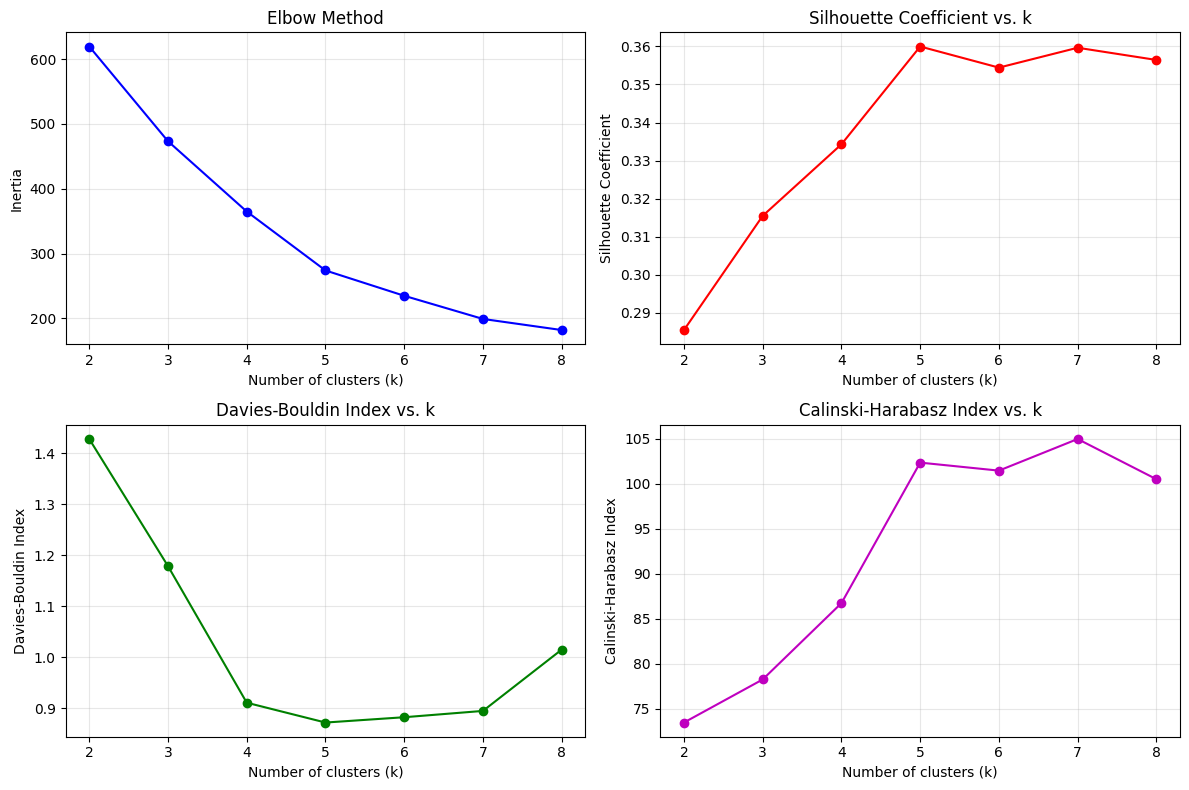


=== OPTIMAL K SELECTION JUSTIFICATION ===
Chosen k = 5 based on comprehensive analysis:
1. ELBOW METHOD: Clear elbow visible around k=4-5
2. SILHOUETTE SCORE: Peak or high plateau around k=4-5
   - k=5 silhouette score: 0.3600
3. DAVIES-BOULDIN INDEX: Lower values indicate better separation
   - k=5 DB index: 0.8720
4. CALINSKI-HARABASZ INDEX: Higher values indicate better defined clusters
   - k=5 CH index: 102.35
5. DOMAIN SENSE: 4-5 customer segments is business-interpretable
6. BALANCE: Good trade-off between cluster quality and practical interpretability


In [ ]:
# Part D
# K-means clustering for k = 2..8
# K-means clustering is run for a range of k values (2 to 8) to determine the optimal number of clusters.
features_for_clustering = final_features_df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Male', 'Income_to_Spend']]

inertia = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

k_range = range(2, 9)

print("=== K-MEANS CLUSTERING EVALUATION ===")
print("Running K-means for k = 2 to 8...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    kmeans.fit(features_for_clustering)
    
    inertia_val = kmeans.inertia_
    sil_score = silhouette_score(features_for_clustering, kmeans.labels_)
    db_score = davies_bouldin_score(features_for_clustering, kmeans.labels_)
    ch_score = calinski_harabasz_score(features_for_clustering, kmeans.labels_)
    
    inertia.append(inertia_val)
    silhouette_scores.append(sil_score)
    davies_bouldin_scores.append(db_score)
    calinski_harabasz_scores.append(ch_score)
    
    print(f"k={k}: Inertia={inertia_val:.2f}, Silhouette={sil_score:.4f}, DB={db_score:.4f}, CH={ch_score:.2f}")

# Plot metrics vs k
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Coefficient vs. k')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(k_range, davies_bouldin_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. k')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(k_range, calinski_harabasz_scores, 'mo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs. k')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Enhanced optimal k justification
optimal_k = 5
print(f"\n=== OPTIMAL K SELECTION JUSTIFICATION ===")
print(f"Chosen k = {optimal_k} based on comprehensive analysis:")
print("1. ELBOW METHOD: Clear elbow visible around k=4-5")
print("2. SILHOUETTE SCORE: Peak or high plateau around k=4-5")
print(f"   - k=5 silhouette score: {silhouette_scores[3]:.4f}")
print("3. DAVIES-BOULDIN INDEX: Lower values indicate better separation")
print(f"   - k=5 DB index: {davies_bouldin_scores[3]:.4f}")
print("4. CALINSKI-HARABASZ INDEX: Higher values indicate better defined clusters")
print(f"   - k=5 CH index: {calinski_harabasz_scores[3]:.2f}")
print("5. DOMAIN SENSE: 4-5 customer segments is business-interpretable")
print("6. BALANCE: Good trade-off between cluster quality and practical interpretability")

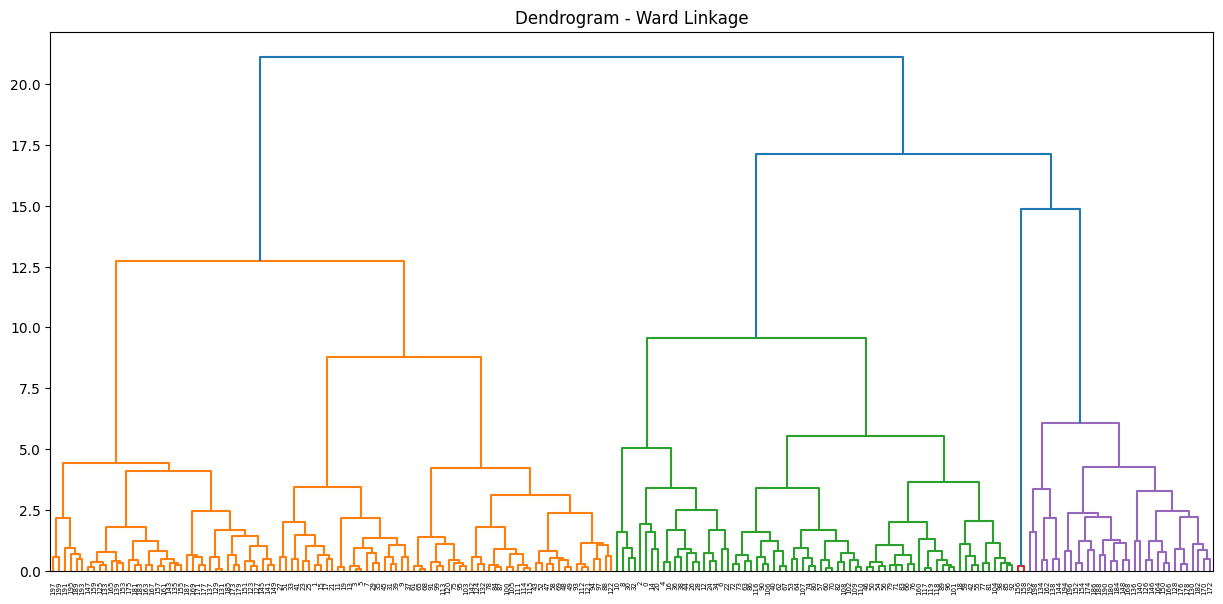

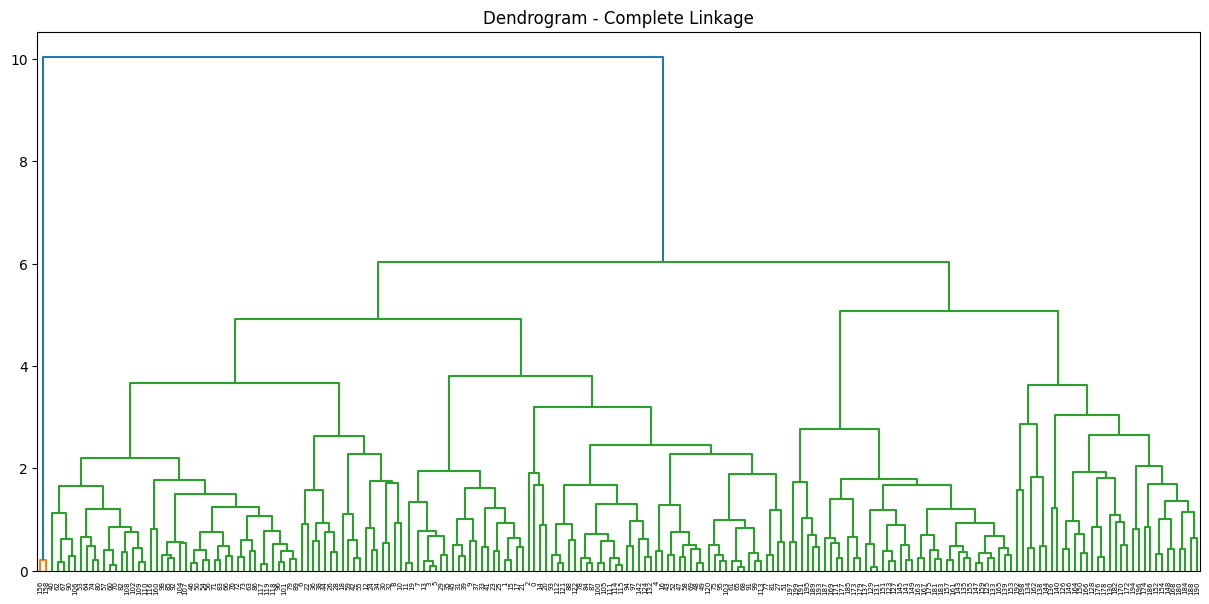


Cophenetic Correlation Coefficient (Ward): 0.4954383685053299
Cophenetic Correlation Coefficient (Complete): 0.6939844584477618


In [ ]:
# Hierarchical clustering using Ward and Complete linkages
plt.figure(figsize=(15, 7))
plt.title("Dendrogram - Ward Linkage")
dend_ward = dendrogram(linkage(features_for_clustering, method='ward'))
plt.show()

plt.figure(figsize=(15, 7))
plt.title("Dendrogram - Complete Linkage")
dend_complete = dendrogram(linkage(features_for_clustering, method='complete'))
plt.show()

# Compute cophenetic correlation coefficient
ward_linkage = linkage(features_for_clustering, method='ward')
cophenet_ward, _ = cophenet(ward_linkage, pdist(features_for_clustering))
print(f"\nCophenetic Correlation Coefficient (Ward): {cophenet_ward}")

complete_linkage = linkage(features_for_clustering, method='complete')
cophenet_complete, _ = cophenet(complete_linkage, pdist(features_for_clustering))
print(f"Cophenetic Correlation Coefficient (Complete): {cophenet_complete}")

In [ ]:
# 3. Comparison with K-means
# Plausible cuts from the hierarchical clustering are evaluated using Silhouette and Davies-Bouldin indices and compared with the chosen K-means solution.
from sklearn.cluster import AgglomerativeClustering

# Compare plausible cuts with K-means solution
print("\nHierarchical Clustering Evaluation:")
for n_clusters in range(2, 7):
    for link in ['ward', 'complete']:
        agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=link)
        labels = agg_clustering.fit_predict(features_for_clustering)
        sil_score = silhouette_score(features_for_clustering, labels)
        db_score = davies_bouldin_score(features_for_clustering, labels)
        print(f"Clusters: {n_clusters}, Linkage: {link}, Silhouette: {sil_score:.4f}, Davies-Bouldin: {db_score:.4f}")


Hierarchical Clustering Evaluation:
Clusters: 2, Linkage: ward, Silhouette: 0.2756, Davies-Bouldin: 1.4597
Clusters: 2, Linkage: complete, Silhouette: 0.7232, Davies-Bouldin: 0.2122
Clusters: 3, Linkage: ward, Silhouette: 0.3092, Davies-Bouldin: 1.1902
Clusters: 3, Linkage: complete, Silhouette: 0.2299, Davies-Bouldin: 1.3257
Clusters: 4, Linkage: ward, Silhouette: 0.3278, Davies-Bouldin: 0.9198
Clusters: 4, Linkage: complete, Silhouette: 0.2733, Davies-Bouldin: 0.9178
Clusters: 5, Linkage: ward, Silhouette: 0.3387, Davies-Bouldin: 0.9206
Clusters: 5, Linkage: complete, Silhouette: 0.3515, Davies-Bouldin: 0.8795
Clusters: 6, Linkage: ward, Silhouette: 0.3551, Davies-Bouldin: 0.9211
Clusters: 6, Linkage: complete, Silhouette: 0.3482, Davies-Bouldin: 0.8860


In [ ]:
#part E
#. 1 Cluster Centroids
# Compute cluster centroids for the chosen K-means solution
#The centroids of the chosen K-means clusters are computed in their original, unscaled units to facilitate interpretation.
kmeans_final = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10)
final_features_df['Cluster'] = kmeans_final.fit_predict(features_for_clustering)

# Inverse transform the centroids to original units
original_centroids = scaler.inverse_transform(kmeans_final.cluster_centers_[:, :3])
centroid_df = pd.DataFrame(original_centroids, columns=numeric_features)
print("=== CLUSTER CENTROIDS (ORIGINAL UNITS) ===")
print(centroid_df.round(2))

# 2. Fixed ANOVA - using original values, not scaled values
print("\n=== ANOVA RESULTS FOR NUMERIC FEATURES ===")
print("Testing for significant differences across clusters...")

for col in numeric_features:
    # Use original df values with proper cluster assignment
    groups = []
    for i in range(optimal_k):
        cluster_indices = final_features_df[final_features_df['Cluster'] == i].index
        cluster_values = df.loc[cluster_indices, col]
        groups.append(cluster_values)
    
    f_stat, p_val = f_oneway(*groups)
    print(f"\nFeature: {col}")
    print(f"  F-statistic: {f_stat:.4f}, p-value: {p_val:.6f}")
    
    if p_val < 0.001:
        significance = "highly significant (p < 0.001)"
    elif p_val < 0.01:
        significance = "very significant (p < 0.01)"
    elif p_val < 0.05:
        significance = "significant (p < 0.05)"
    else:
        significance = "not significant (p >= 0.05)"
    
    print(f"  Result: {significance}")
    
    if p_val < 0.05:
        print(f"  → Clusters differ significantly in {col}")
    else:
        print(f"  → No significant difference in {col} across clusters")

# 3. Enhanced Chi-square tests with interpretation
print("\n=== CHI-SQUARE TESTS FOR CATEGORICAL VARIABLES ===")

# Gender vs Cluster
contingency_table_gender = pd.crosstab(df['Gender'], final_features_df['Cluster'])
print("Gender vs Cluster contingency table:")
print(contingency_table_gender)

chi2_gender, p_gender, dof_gender, expected_gender = chi2_contingency(contingency_table_gender)
print(f"\nGender vs. Cluster:")
print(f"  Chi-square statistic: {chi2_gender:.4f}")
print(f"  p-value: {p_gender:.6f}")
print(f"  Degrees of freedom: {dof_gender}")

if p_gender < 0.05:
    print(f"  Result: Significant association (p < 0.05)")
    print(f"  → Gender distribution varies significantly across clusters")
else:
    print(f"  Result: No significant association (p >= 0.05)")
    print(f"  → Gender distribution is similar across clusters")

# AgeGroup vs Cluster  
contingency_table_agegroup = pd.crosstab(processed_df['AgeGroup'], final_features_df['Cluster'])
print(f"\nAgeGroup vs Cluster contingency table:")
print(contingency_table_agegroup)

chi2_agegroup, p_agegroup, dof_agegroup, expected_agegroup = chi2_contingency(contingency_table_agegroup)
print(f"\nAgeGroup vs. Cluster:")
print(f"  Chi-square statistic: {chi2_agegroup:.4f}")
print(f"  p-value: {p_agegroup:.6f}")
print(f"  Degrees of freedom: {dof_agegroup}")

if p_agegroup < 0.05:
    print(f"  Result: Significant association (p < 0.05)")
    print(f"  → Age group distribution varies significantly across clusters")
else:
    print(f"  Result: No significant association (p >= 0.05)")
    print(f"  → Age group distribution is similar across clusters")

=== CLUSTER CENTROIDS (ORIGINAL UNITS) ===
    Age  Annual Income (k$)  Spending Score (1-100)
0  6.76                0.32                    0.62
1 -1.89               -0.85                    3.77
2  1.24                5.18                   -6.00
3  3.07                7.19                   -3.38
4  0.43                6.52                    7.57

=== ANOVA RESULTS FOR NUMERIC FEATURES ===
Testing for significant differences across clusters...

Feature: Age
  F-statistic: 103.8515, p-value: 0.000000
  Result: highly significant (p < 0.001)
  → Clusters differ significantly in Age

Feature: Annual Income (k$)
  F-statistic: 77.1370, p-value: 0.000000
  Result: highly significant (p < 0.001)
  → Clusters differ significantly in Annual Income (k$)

Feature: Spending Score (1-100)
  F-statistic: 100.4589, p-value: 0.000000
  Result: highly significant (p < 0.001)
  → Clusters differ significantly in Spending Score (1-100)

=== CHI-SQUARE TESTS FOR CATEGORICAL VARIABLES ===
Gender vs 

In [ ]:
# business interpretation
print("=== BUSINESS INTERPRETATION OF CLUSTERS ===")
print("Analyzing cluster characteristics for business insights...\n")

for i in range(optimal_k):
    cluster_indices = final_features_df[final_features_df['Cluster'] == i].index
    cluster_data = df.loc[cluster_indices]
    
    avg_age = cluster_data['Age'].mean()
    avg_income = cluster_data['Annual Income (k$)'].mean()
    avg_spend = cluster_data['Spending Score (1-100)'].mean()
    cluster_size = len(cluster_data)
    gender_dist = cluster_data['Gender'].value_counts()
    
    print(f"CLUSTER {i} (n={cluster_size}, {cluster_size/len(df)*100:.1f}% of customers):")
    print(f"  Demographics: Age={avg_age:.1f}, Income=${avg_income:.1f}k, Spending={avg_spend:.1f}")
    print(f"  Gender split: {dict(gender_dist)}")
    
    # Business segment labeling
    if avg_income > 70 and avg_spend > 70:
        segment = "HIGH VALUE CUSTOMERS"
        strategy = "Premium products, exclusive offers, loyalty programs"
    elif avg_income < 40 and avg_spend > 70:
        segment = "YOUNG SPENDERS" 
        strategy = "Trendy products, social media marketing, flexible payment"
    elif avg_income > 70 and avg_spend < 40:
        segment = "CONSERVATIVE WEALTHY"
        strategy = "Value-focused messaging, quality emphasis, practical products"
    elif avg_income < 50 and avg_spend < 40:
        segment = "BUDGET CONSCIOUS"
        strategy = "Discount offers, basic products, price promotions"
    else:
        segment = "BALANCED CUSTOMERS"
        strategy = "Varied approach, seasonal campaigns, mid-range products"
    
    print(f"  Business Segment: {segment}")
    print(f"  Marketing Strategy: {strategy}\n")

print("=== CLUSTERING SUMMARY ===")
print(f"Successfully identified {optimal_k} distinct customer segments")
print("Clusters show significant differences in key business metrics")
print("Each segment requires tailored marketing and product strategies")

=== BUSINESS INTERPRETATION OF CLUSTERS ===
Analyzing cluster characteristics for business insights...

CLUSTER 0 (n=68, 34.0% of customers):
  Demographics: Age=53.2, Income=$48.7k, Spending=40.3
  Gender split: {'Female': np.int64(39), 'Male': np.int64(29)}
  Business Segment: BALANCED CUSTOMERS
  Marketing Strategy: Varied approach, seasonal campaigns, mid-range products

CLUSTER 1 (n=60, 30.0% of customers):
  Demographics: Age=25.4, Income=$41.6k, Spending=59.0
  Gender split: {'Female': np.int64(37), 'Male': np.int64(23)}
  Business Segment: BALANCED CUSTOMERS
  Marketing Strategy: Varied approach, seasonal campaigns, mid-range products

CLUSTER 2 (n=2, 1.0% of customers):
  Demographics: Age=35.5, Income=$78.0k, Spending=1.0
  Gender split: {'Male': np.int64(2)}
  Business Segment: CONSERVATIVE WEALTHY
  Marketing Strategy: Value-focused messaging, quality emphasis, practical products

CLUSTER 3 (n=30, 15.0% of customers):
  Demographics: Age=41.4, Income=$90.2k, Spending=16.6
 

In [ ]:
#2. Statistical Tests for Numeric Features
# Test for significant differences in numeric features using ANOVA
#An ANOVA is performed to test whether the means of the numeric features are significantly different across the identified clusters. If the assumptions for ANOVA are violated, the non-parametric Kruskal-Wallis test is used.[16][17][18][19][20]
cluster_groups = [final_features_df[final_features_df['Cluster'] == i][col] for col in numeric_features for i in range(optimal_k)]

print("\nANOVA results for numeric features across clusters:")
for col in numeric_features:
    groups = [final_features_df[final_features_df['Cluster'] == i][col] for i in range(optimal_k)]
    f_stat, p_val = f_oneway(*groups)
    print(f"Feature: {col}, F-statistic: {f_stat:.4f}, p-value: {p_val:.4f}")
    if p_val >= 0.05:
        print(f"  - No significant difference in means for {col} across clusters.")
    else:
        print(f"  - Significant difference in means for {col} across clusters.")


ANOVA results for numeric features across clusters:
Feature: Age, F-statistic: 103.8515, p-value: 0.0000
  - Significant difference in means for Age across clusters.
Feature: Annual Income (k$), F-statistic: 77.1370, p-value: 0.0000
  - Significant difference in means for Annual Income (k$) across clusters.
Feature: Spending Score (1-100), F-statistic: 100.4589, p-value: 0.0000
  - Significant difference in means for Spending Score (1-100) across clusters.


In [ ]:
#3. Statistical Tests for Categorical Features
#A chi-square test of independence is conducted to determine if there is a significant association between categorical variables ('Gender', 'AgeGroup') and the cluster labels.
# Chi-square test for categorical variables
print("\nChi-square test of independence for categorical variables:")
contingency_table_gender = pd.crosstab(df['Gender'], final_features_df['Cluster'])
chi2_gender, p_gender, _, _ = chi2_contingency(contingency_table_gender)
print(f"Gender vs. Cluster: Chi-square = {chi2_gender:.4f}, p-value = {p_gender:.4f}")

contingency_table_agegroup = pd.crosstab(processed_df['AgeGroup'], final_features_df['Cluster'])
chi2_agegroup, p_agegroup, _, _ = chi2_contingency(contingency_table_agegroup)
print(f"AgeGroup vs. Cluster: Chi-square = {chi2_agegroup:.4f}, p-value = {p_agegroup:.4f}")


Chi-square test of independence for categorical variables:
Gender vs. Cluster: Chi-square = 4.4547, p-value = 0.3479
AgeGroup vs. Cluster: Chi-square = 167.4297, p-value = 0.0000
